In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median__illposed import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
# problem_spec['translation'] = "b"
problem_spec['translation'] = "rand"
problem_spec['sc_index_set'] = {3,4}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

# problem_spec['sc_theta'] = 2
# problem_spec['sc_theta'] = 1
# problem_spec['sc_theta'] = 0.7
# problem_spec['sc_theta'] = 0.5
# problem_spec['sc_theta'] = 0.3
# problem_spec['sc_theta'] = 0.001
# problem_spec['sc_theta'] = 0.00001
problem_spec['sc_theta'] = 1e-10


# problem_spec['rescale'] = 1e-4
problem_spec['rescale'] = 1

problem_data['itr_num'] = 1000
# problem_data['itr_num'] = 200
# problem_data['itr_num'] = 100

{'n_node': 6, 'vector_size': 100, 'translation': 'rand', 'sc_index_set': {3, 4}}


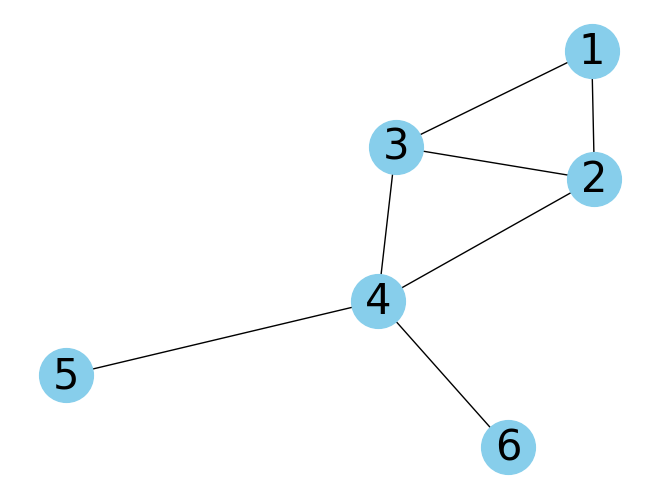

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=2323.5304141071065, np.linalg.norm(x_opt_star)=0.5413632105727102


In [5]:
b = problem_data['b']
c = problem_data['c']
Q = problem_data['Q']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
rescale = problem_spec['rescale']
sc_index_set = problem_spec['sc_index_set']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj, Qj=Qj:  prox_fj_geom_mean_sc(z, rho, bj, cj, Qj, theta=theta)]
        # prox_operators += [lambda z, rho, bj=bj, cj=cj, Qj=Qj, vector_size=vector_size:  cvx_prox_fj_geom_mean_sc(z, rho, bj, cj, Qj, vector_size, theta=theta)]        
        # fi_operators += [lambda x_kj, bj=bj, cj=cj, Qj=Qj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm( Qj @ x_kj - cj, ord=2)**2]
        fi_operators += [lambda x_kj, bj=bj, cj=cj, Qj=Qj: theta*np.linalg.norm( Qj @ x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj, rescale=rescale:  prox_fj_geom_mean(z, rho, bj, rescale)]
        fi_operators += [lambda x_kj, bj=bj: rescale * np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj, rescale)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, rescale, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, Qj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, Qj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

In [6]:
for j in sc_index_set:
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])
    
for j in sc_index_set:
    U, s, V = np.linalg.svd(Q[j])
    s = np.sqrt(theta) * s
    print([np.max(s), np.average(s), np.min(s)])

[999999.9999999997, 335347.13636363635, 0.9999999999476253]
[999999.9999999987, 335347.13636363647, 1.000000000049279]
[9.999999999999996, 3.353471363636363, 9.999999999476255e-06]
[9.999999999999988, 3.3534713636363644, 1.0000000000492791e-05]


## Find best parameter for DADMM

In [7]:
find_best = True

# start, end, space = 0.00001, 0.00005, 0.000001
# start, end, space = 0.0001, 0.0005, 0.00001
# start, end, space = 0.0001, 0.001, 0.0001
# start, end, space = 0.001, 0.01, 0.001
start, end, space = 0.01, 0.3, 0.01
# start, end, space = 0.2, 0.5, 0.01
# start, end, space = 0.1, 4, 0.05
# start, end, space = 0.5, 4, 0.5
# start, end, space = 0.5, 10, 0.5
# start, end, space = 10, 100, 10

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 6)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[50:150]) / 100
        # new_val = sum(admm_f_reldiff[50:350]) / 300
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", R,  ", new best_value :", new_val)
            best_value = new_val
            best_R = R

print("best_R :", best_R)

new best_R : 0.01 , new best_value : 5.906365984998385e-06
new best_R : 0.02 , new best_value : 1.7236346750454522e-06
new best_R : 0.03 , new best_value : 5.710317072359565e-07
new best_R : 0.04 , new best_value : 1.9269104282806146e-07
new best_R : 0.05 , new best_value : 6.16323890463854e-08
new best_R : 0.06 , new best_value : 1.592436167430438e-08
new best_R : 0.07 , new best_value : 2.341294326417837e-09
new best_R : 0.12 , new best_value : 2.0370893716891747e-09
new best_R : 0.13 , new best_value : 1.4270923687585782e-09
new best_R : 0.14 , new best_value : 9.722808479809842e-10
new best_R : 0.15 , new best_value : 6.467468326548579e-10
new best_R : 0.16 , new best_value : 4.2091155647366413e-10
new best_R : 0.17 , new best_value : 2.686215136949591e-10
new best_R : 0.18 , new best_value : 1.689207900104181e-10
new best_R : 0.19 , new best_value : 1.0587229936705321e-10
new best_R : 0.2 , new best_value : 7.986850697952011e-11
best_R : 0.2


In [8]:
R = best_R
# R = 0.6
# R = 0.0001
# R = 100
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.00013817282924499883, err_opt_reldiff[-1]=1.0063690390320148
ii=200, f_reldiff[-1]=1.338896851010824e-08, err_opt_reldiff[-1]=0.0010002188249123634
ii=400, f_reldiff[-1]=3.172719091802106e-12, err_opt_reldiff[-1]=2.4384299021240175e-05
ii=600, f_reldiff[-1]=3.248851824311576e-14, err_opt_reldiff[-1]=2.3304214889081795e-05
ii=800, f_reldiff[-1]=1.4287119468358135e-14, err_opt_reldiff[-1]=2.3302785637058825e-05
ii=999, f_reldiff[-1]=1.4091405503038161e-14, err_opt_reldiff[-1]=2.330278400679849e-05


## Find best parameter of P-EXTRA

In [9]:
# apply P-EXTRA 
find_best = True

# start, end, space = 0.00001, 0.0001, 0.00001
# start, end, space = 0.0001, 0.001, 0.0001
# start, end, space = 0.001, 0.01, 0.001
start, end, space = 0.01, 0.1, 0.01
# start, end, space = 0.05, 2, 0.05
# start, end, space = 0.5, 10, 0.5
# start, end, space = 2, 20, 2
# start, end, space = 10, 100, 10
# start, end, space = 100, 1000, 100

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        rho = round(r, 5)
        problem_data['rho'] = rho
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                                    network_data, x_opt_star, f_star, 
                                                                                                    printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[50:350]) / 300
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", rho, "new best_value :", new_val)
            best_value = new_val
            best_rho = rho

print("best_rho :", best_rho)

new best_rho : 0.01 new best_value : 1.1601175763231917e-06
new best_rho : 0.02 new best_value : 7.070730305620482e-08
new best_rho : 0.03 new best_value : 1.095962902711079e-08
new best_rho : 0.04 new best_value : 9.304912486070963e-09
new best_rho : 0.05 new best_value : 4.159295126581098e-09
best_rho : 0.05


In [10]:
# apply P-EXTRA 
problem_data['rho'] = best_rho
# problem_data['rho'] = 1000000000
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                            network_data, x_opt_star, f_star, 
                                                                                            printing=True, freq=200)

ii=0, f_reldiff[-1]=3.774913078769088e-05, err_opt_reldiff[-1]=0.9785043765179211
ii=200, f_reldiff[-1]=4.708314349378464e-08, err_opt_reldiff[-1]=0.018282992265024955
ii=400, f_reldiff[-1]=2.343340063825997e-10, err_opt_reldiff[-1]=0.0004994529111704446
ii=600, f_reldiff[-1]=2.6248765600784333e-11, err_opt_reldiff[-1]=3.449622511951885e-05
ii=800, f_reldiff[-1]=9.302284771658386e-13, err_opt_reldiff[-1]=2.3577422754244265e-05
ii=999, f_reldiff[-1]=4.1099932717194636e-14, err_opt_reldiff[-1]=2.3310232624602363e-05


## DADMM-C

In [56]:
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937}
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284}
# params={"R":2, "Inductance":3, "Capacitance":0.5, "h":0.71692315906863}
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931}
# params={"R":2, "Inductance":1, "Capacitance":1, "h":0.665836807162538}
# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":3.50141019655701}
# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567}
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.515416990114254}
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}

### not verified parameters
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":2.4} # Work well for theta=0.3
# params={"R":2, "Inductance":3, "Capacitance":4, "h":3} # Work great for theta=0.5
# params={"R":2, "Inductance":3.1, "Capacitance":47, "h":3} 
# params={"R":2, "Inductance":3.3, "Capacitance":17, "h":3}  # Dont work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":3, "h":3} # Work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.1785158094003885} # from solver
# params={"R":0.85, "Inductance":2, "Capacitance":14, "h":4.8} # not bad for theta=1, good for theta=2
# params={"R":0.8, "Inductance":2, "Capacitance":12, "h":4.5} # good for theta=1
# params={"R":1.3, "Inductance":2, "Capacitance":8, "h":3.5}
# params={"R":1.2, "Inductance":2, "Capacitance":14, "h":4.7} # works no bad for theta=2




# params={"R":0.02, "Inductance":0.02, "Inductance_S":0.02, "Capacitance":100, "h":1} # Same as DADMM

# params={"R":0.02, "Inductance":0.008, "Inductance_S":0.01, "Capacitance":100, "h":1} # little better

# params={"R":0.03, "Inductance":0.015, "Inductance_S":0.03, "Capacitance":100, "h":1.3} # little better

# params={"R":0.025, "Inductance":0.01, "Inductance_S":0.024, "Capacitance":80, "h":1.1} # little better

# params={"R":0.025, "Inductance":0.01, "Inductance_S":0.04, "Capacitance":60, "h":1.1} # little better


# params={"R":0.2, "Inductance":0.16, "Inductance_S":0.16, "Capacitance":12.5, "h":1} # Same as DADMM

# params={"R":0.2, "Inductance":0.2, "Inductance_S":0.11, "Capacitance":12.5, "h":1} # slightly better

# params={"R":0.2, "Inductance":0.2, "Inductance_S":0.2, "Capacitance":10, "h":1} # Same as DADMM

params={"R":0.2, "Inductance":0.1, "Inductance_S":0.1, "Capacitance":10, "h":1} # slightly better

# params={"R":0.3, "Inductance":0.2, "Inductance_S":0.16, "Capacitance":20, "h":1} # slightly better

# params={"R":0.37, "Inductance":0.37, "Inductance_S":0.37, "Capacitance":5.4, "h":1} # Same as DADMM

# params={"R":0.37, "Inductance":0.185, "Inductance_S":0.19, "Capacitance":5.4, "h":1} # Slightly better

# params={"R":0.45, "Inductance":0.45, "Inductance_S":0.45, "Capacitance":4.4, "h":1} # Slightly better

# params={"R":0.45, "Inductance":0.25, "Inductance_S":0.25, "Capacitance":4.4, "h":1} # Slightly better

# params={"R":2.3e-05, "Inductance":2.3e-05, "Inductance_S":2.3e-05, "Capacitance":86956, "h":1} # Same as DADMM

# params={"R":2.3e-05, "Inductance":2.3e-05, "Inductance_S":1.4e-05, "Capacitance":90000, "h":1} # almost same

# params={"R":3e-05, "Inductance":2e-05, "Inductance_S":2e-05, "Capacitance":90000, "h":1.3} # better?
 
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff  = co.dadmm("cir_dadmm_c2", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.00013817282924499883, err_opt_reldiff[-1]=1.0063690390320148
ii=200, f_reldiff[-1]=2.6984201925406853e-09, err_opt_reldiff[-1]=0.0017562753764029807
ii=400, f_reldiff[-1]=8.04306111878967e-12, err_opt_reldiff[-1]=2.7185745334224652e-05
ii=600, f_reldiff[-1]=3.5815655653555324e-14, err_opt_reldiff[-1]=2.3312829273058578e-05
ii=800, f_reldiff[-1]=1.4091405503038161e-14, err_opt_reldiff[-1]=2.330281111448426e-05
ii=999, f_reldiff[-1]=1.4091405503038161e-14, err_opt_reldiff[-1]=2.330278394821761e-05


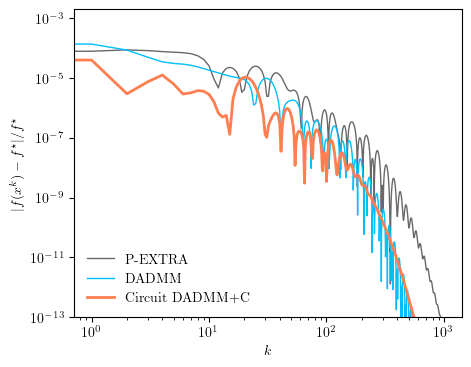

In [57]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])

# co.plot_methods([pg_f_reldiff,admm_f_reldiff,dadmm_c_f_reldiff],
#                 ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-13, 2e-0, fname)

co.plot_methods([pg_f_reldiff,admm_f_reldiff,dadmm_c_f_reldiff],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-13, 2e-3, fname)

In [58]:
np.where(np.array(admm_f_reldiff) < 1e-7)[0][0]

41

In [59]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-7)[0][0]

41

In [15]:
#good parameters near 0.0001


# params={"R":0.00022, "Inductance":0.00011, "Capacitance":4545.45, "h":0.5} # equals to DADMM
# params={"R":0.00022, "Inductance":0.00008, "Capacitance":3900, "h":0.5} 
# params={"R":0.00022, "Inductance":0.00022, "Capacitance":10000, "h":1.3} 


# params={"R":0.00022, "Inductance":0.00011, "Capacitance":4000, "h":0.5} # equals to DADMM

# params={"R":0.0003, "Inductance":0.00022, "Capacitance":8500, "h":1.3}  # best

# params={"R":0.0004, "Inductance":0.00022, "Capacitance":6000, "h":1} # work better
# params={"R":0.0004, "Inductance":0.00022, "Capacitance":12000, "h":1} # work better
# params={"R":0.0004, "Inductance":0.0003, "Capacitance":20000, "h":1.4} # work better
# params={"R":0.0004, "Inductance":0.0004, "Capacitance":20000, "h":1.9} # work better



# params={"R":0.0001, "Inductance":0.0001, "Inductance_S":0.0001, "Capacitance":20000, "h":0.5} # equals to DADMM

# params={"R":0.00021, "Inductance":0.000105, "Inductance_S":0.000105, "Capacitance":4761, "h":0.5} # equals to DADMM

# params={"R":0.0003, "Inductance":0.00039, "Inductance_S":0.00039, "Capacitance":8666, "h":1.3} # Same as DADMM

# params={"R":0.0003, "Inductance":0.0002, "Inductance_S":0.00023, "Capacitance":14000, "h":1.5} # quite good

# params={"R":0.0003, "Inductance":0.0002, "Inductance_S":0.00023, "Capacitance":11000, "h":1.5} # quite good

# params={"R":0.0004, "Inductance":0.0006, "Inductance_S":0.0006, "Capacitance":7500, "h":1.5} # Same as DADMM

# params={"R":0.0004, "Inductance":0.0004, "Inductance_S":0.0004, "Capacitance":8000, "h":1.7} # Not that much good

# params={"R":0.0003, "Inductance":0.00022, "Inductance_S":0.00022, "Capacitance":8300, "h":1.3} # Works better

# params={"R":0.0003, "Inductance":0.00015, "Inductance_S":0.00022, "Capacitance":8300, "h":1.3} # best

# params={"R":0.0003, "Inductance":0.00022, "Inductance_S":0.0004, "Capacitance":8300, "h":1.5}  #soso



# params={"R":0.001, "Inductance":0.0005, "Inductance_S":0.0009, "Capacitance":2000, "h":1.2}  # worse, when R=0.0002is the best